In [64]:
!pip install -i https://test.pypi.org/simple/ mlutils --upgrade

Looking in indexes: https://test.pypi.org/simple/


In [65]:
from importlib import reload

import pandas as pd
from mlutils.preprocessing import preprocessing
from mlutils.tensorflowutils import tensorflowutils

In [66]:
reload(preprocessing)
reload(tensorflowutils)

<module 'mlutils.tensorflowutils.tensorflowutils' from '/home/alessiosavi/anaconda3/envs/ml/lib/python3.9/site-packages/mlutils/tensorflowutils/tensorflowutils.py'>

In [4]:
df = pd.read_csv(
    "dataset/jena_climate_2009_2016.zip", compression="zip", low_memory=False
)

In [5]:
df = df[["Date Time", "T (degC)", "rh (%)"]]
df.head()

,Date Time,T (degC),rh (%)
0,01.01.2009 00:10:00,-8.02,93.3
1,01.01.2009 00:20:00,-8.41,93.4
2,01.01.2009 00:30:00,-8.51,93.9
3,01.01.2009 00:40:00,-8.31,94.2
4,01.01.2009 00:50:00,-8.27,94.1


In [6]:
df = preprocessing.set_time_index(df, "Date Time", time_format="%d.%m.%Y %H:%M:%S")
del df["Date Time"]

In [7]:
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 420551 entries, 2009-01-01 00:10:00 to 2017-01-01 00:00:00
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   T (degC)  420551 non-null  float64
 1   rh (%)    420551 non-null  float64
dtypes: float64(2)
memory usage: 9.6 MB


In [8]:
df.head()

,T (degC),rh (%)
Date Time,,
2009-01-01 00:10:00,-8.02,93.3
2009-01-01 00:20:00,-8.41,93.4
2009-01-01 00:30:00,-8.51,93.9
2009-01-01 00:40:00,-8.31,94.2
2009-01-01 00:50:00,-8.27,94.1


In [9]:
df = preprocessing.resample_df(df, 86400)
df.info(verbose=True, memory_usage=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2923 entries, 2009-01-01 to 2017-01-01
Freq: 86400S
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   T (degC)  2923 non-null   float64
 1   rh (%)    2923 non-null   float64
dtypes: float64(2)
memory usage: 68.5 KB


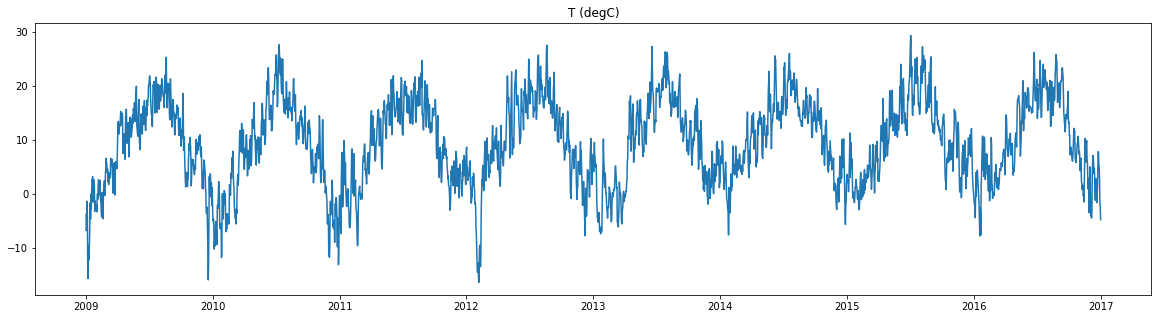

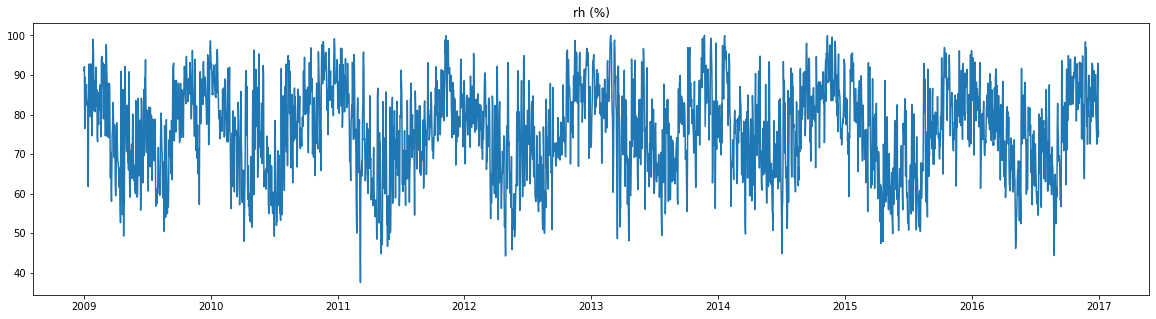

In [10]:
import matplotlib.pyplot as plt

for i in df.columns:
    plt.figure(figsize=(20, 5))
    plt.title(i)
    plt.plot(df[i])

In [11]:
df.describe()

,T (degC),rh (%)
count,2923.000000,2923.000000
mean,9.438695,76.043056
std,7.836859,11.375917
min,-16.457292,37.580347
25%,3.811007,67.691319
50%,9.708333,76.988472
75%,15.419062,84.577604
max,29.375347,100.000000


# TENSORFLOW

In [12]:
import tensorflow as tf
from tensorflow.keras import mixed_precision

policy = mixed_precision.Policy("mixed_float16")
mixed_precision.set_global_policy(policy)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


2021-11-24 21:19:46.271300: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 21:19:46.275244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 21:19:46.275533: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-24 21:19:46.276107: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [13]:
df.head()

,T (degC),rh (%)
Date Time,,
2009-01-01,-6.810629,91.086014
2009-01-02,-3.728194,92.086806
2009-01-03,-5.271736,76.458056
2009-01-04,-1.375208,89.417361
2009-01-05,-4.867153,86.260417


## Scale data

In [14]:
from sklearn.preprocessing import StandardScaler

scaler = {}
columns = {}
for column in df.columns:
    sc = StandardScaler()
    scaler[column] = sc
    df_scaled = sc.fit_transform(df[column].to_numpy().reshape(-1, 1))
    columns[column] = df_scaled.ravel()
# df_scaled = pd.DataFrame(df_scaled, columns=df.columns)

<AxesSubplot:>

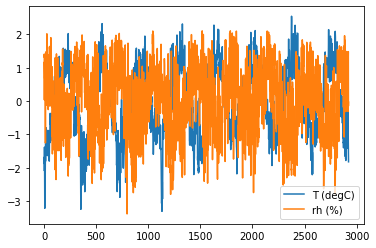

In [15]:
df_scaled = pd.DataFrame(columns)
df_scaled.plot()

In [16]:
df.head()

,T (degC),rh (%)
Date Time,,
2009-01-01,-6.810629,91.086014
2009-01-02,-3.728194,92.086806
2009-01-03,-5.271736,76.458056
2009-01-04,-1.375208,89.417361
2009-01-05,-4.867153,86.260417


In [17]:
numpy_x = df_scaled.values
# numpy_x = df.values
# numpy_x = numpy_x.reshape(numpy_x.shape[0], 1)
numpy_x.shape

(2923, 2)

In [18]:
numpy_x.shape

(2923, 2)

In [19]:
# Use 370 days as history, predict 7 days
history_window = 370
n_prediction = 7
n_features = numpy_x.shape[1]
df_x, df_y = preprocessing.split_sequence(numpy_x, history_window, n_prediction)

In [20]:
def get_predict_columns(df: pd.DataFrame, feature_name: str) -> int:
    for i in range(len(df.columns)):
        if df.columns[i] == feature_name:
            return i
    raise Exception("No column found")


feature_to_predict = get_predict_columns(df, "T (degC)")

In [21]:
df_y = df_y[:, :, feature_to_predict]

In [22]:
df_x.shape, df_y.shape

((2547, 370, 2), (2547, 7))

In [23]:
# Reshaping into n_example, timestamps, features
df_x = df_x.reshape(df_x.shape[0], df_x.shape[1], n_features)
df_x.shape

(2547, 370, 2)

In [24]:
# Reshaping in n_example, timestamps
df_y = df_y.reshape(df_y.shape[0], df_y.shape[1])
df_y.shape

(2547, 7)

In [25]:
# Reduce memory usage for Low End graphic cards
# df_x = np.float16(df_x)
# df_y = np.float16(df_y)

In [73]:
example_conf = """
{
    "model_type": "Sequential",
    "input_shape": [
        370,
        2
    ],
    "model_conf": [
        {
            "layer": "LSTM",
            "layer_conf": {"units": 1024, "return_sequences": true }
        },
        {
            "layer": "LSTM",
            "layer_conf": {"units": 512,"return_sequences": true}
        },
        {
            "layer": "LSTM",
            "layer_conf": {"units": 256}
        },
        {
            "layer": "DENSE",
            "layer_conf": {"units": 7}
        }
    ],
    "compile_conf": {
        "optimizer": "adam",
        "loss": "mse",
        "metrics": "mae"
    }
}
"""

In [74]:
import json

c = json.loads(example_conf)
callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=10, restore_best_weights=True
)

model = tensorflowutils.train_model(
    c, df_x[:-1], df_y[:-1], epochs=1000, callbacks=[callback], batch_size=256
)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_25 (LSTM)              (None, 370, 1024)         4206592   
                                                                 
 lstm_26 (LSTM)              (None, 370, 512)          3147776   
                                                                 
 lstm_27 (LSTM)              (None, 256)               787456    
                                                                 
 dense_9 (Dense)             (None, 7)                 1799      
                                                                 
Total params: 8,143,623
Trainable params: 8,143,623
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
10/10 [==============================] - 5s 181ms/step - loss: 0.6684 - mae: 0.6084
Epoch 2/1000
10/10 [==============================] - 2s 187ms/step - loss: 0.3

INFO:tensorflow:Assets written to: model_dir/LSTM_LSTM_LSTM_DENSE/4/assets


INFO:tensorflow:Assets written to: model_dir/LSTM_LSTM_LSTM_DENSE/4/assets


In [75]:
# Reshape input in order to have a single example with `history_window` timestamp
model_input = df_x[-1].reshape(1, history_window, n_features)

In [76]:
model_prediction = model.predict(model_input).ravel()

In [77]:
d = {
    "real_values": scaler["T (degC)"]
    .inverse_transform(df_y[-1].reshape(-1, 1))
    .ravel(),
    "model_values": scaler["T (degC)"]
    .inverse_transform(model_prediction.reshape(-1, 1))
    .ravel(),
}

<AxesSubplot:>

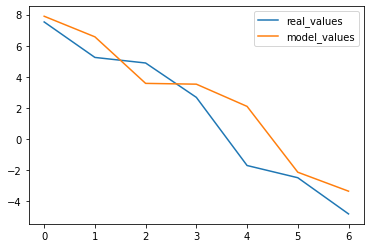

In [78]:
pd.DataFrame(d).plot()